<a href="https://colab.research.google.com/github/amiralv82/VAE_Cancer_Detection/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rd
import tensorflow as tf
from tensorflow.keras import Model, layers, optimizers
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler

# 1. Data Loading and Preprocessing
> **This function loads the gene expression data from a text file and prepares it so that each row is a sample (e.g., from a patient), and each column is a gene.**





In [2]:
# Function to read data
def get_data(din):
    # Reads TSV file, transposes, and sets genes as columns
    bf = pd.read_csv(din, sep='\t')
    genes = bf['Hugo_Symbol']
    cols = list(bf.columns)
    cols.remove('Entrez_Gene_Id')
    cols.remove('Hugo_Symbol')
    bf = bf[cols].transpose()
    bf.columns = genes
    return bf

# Get dataset
def getDataset(din1, din2, din3):
    # Combines datasets and creates train/test splits
    normal1 = get_data(din1)
    normal2 = get_data(din2)
    abnormal = get_data(din3)

    # Keeps only common genes across all datasets
    common_genes = normal1.columns.intersection(normal2.columns).intersection(abnormal.columns)
    normal1 = normal1[common_genes]
    normal2 = normal2[common_genes]
    abnormal = abnormal[common_genes]

    X_train = pd.concat([normal1, normal2]).values.astype(np.float32)

    # Creates test set with normal (0) and abnormal (1) samples
    test_normal = normal1.sample(n=60, random_state=42).values.astype(np.float32)
    test_abnormal = abnormal.sample(n=25, random_state=42).values.astype(np.float32)
    X_test = np.vstack([test_normal, test_abnormal])
    y_test = np.concatenate([np.zeros(60), np.ones(25)])

    return X_train, X_test, y_test

# 2. Data Normalization
> **This combines two healthy datasets and one cancer dataset. It uses the healthy data to train the model and mixes healthy and cancerous samples for testing.**


> **Applies Min-Max scaling to normalize all gene expression values to the range [0, 1], which improves neural network convergence, especially with sigmoid outputs.
It scales the values so they all fit between 0 and 1 — important for stable training.**

In [3]:
# Load and preprocess data
din1 = 'breast-rsem-fpkm-gtex.txt'
din2 = 'brca-rsem-fpkm-tcga.txt'
din3 = 'brca-rsem-fpkm-tcga-t.txt'

X_train, X_test, y_test = getDataset(din1, din2, din3)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train) # Scales to [0,1]
X_test = scaler.transform(X_test)

## Variational Autoencoder (VAE) Formulation

A VAE is a probabilistic generative model defined as follows:

**Given** input $( x in \mathbb{R}^D )$, the encoder approximates the posterior:

$$
q_\phi(z|x) = \mathcal{N}(z; \mu(x), \sigma^2(x) I)
$$

where $(\mu(x))$ and $( \sigma^2(x) )$ are outputs of the encoder network parameterized by $(\phi)$.

**The decoder** reconstructs $(x)$ from latent variable $( z \sim q_\phi(z|x) )$:

$$
p_\theta(x|z)
$$

**Objective**: Maximize the Evidence Lower Bound (ELBO):

$$
\mathcal{L}(x) = \mathbb{E}_{q_\phi(z|x)}\left[\log p_\theta(x|z)\right] - \text{KL}\left(q_\phi(z|x) \,\|\, p(z)\right)
$$

Where:
- $( \text{KL}(\cdot \|\cdot) )$ is the Kullback-Leibler divergence
- $( p(z) = \mathcal{N}(0, I) )$ is the standard normal prior

# 1. Encoder
* The encoder maps  $x \rightarrow (\mu, \log \sigma^2)$ , parameterizing a
diagonal Gaussian.
* z_mean =  $\mu$
* z_log_var =  $\log \sigma^2 $


> It compresses the input into a smaller representation (mean and variance) — like summarizing the sample using fewer values.


#2. Sampling Layer (Reparameterization Trick)

$$z = \mu + \sigma \cdot \epsilon \quad \text{where } \epsilon \sim \mathcal{N}(0, I)$$
> **Enables gradients to flow through the stochastic sampling step.**

> **It picks a random point around the mean using the predicted variance — adding randomness but keeping it learnable.**

#3. Decoder
* Maps latent  $z$  back to input space  $\hat{x} \approx x$ .
* Final activation sigmoid matches normalized input [0,1].

>	It tries to reconstruct the original input from the compressed version.

#4. Loss Function


1.   **Reconstruction Loss:**

$$\mathcal{L}{\text{rec}} = \mathbb{E}{q(z|x)}[\log p(x|z)] \approx \text{BinaryCrossentropy}(x, \hat{x})$$

2.   **KL Divergence:**

$$\text{KL}(q(z|x) \| p(z)) = \frac{1}{2} \sum_j \left(1 + \log \sigma_j^2 - \mu_j^2 - \sigma_j^2\right)$$

**One loss says how well we reconstruct the input; the other says how close our compressed data is to a normal distribution.**

#5. Model Training
*	Input = Output =  x : It’s an autoencoder — reconstruct the input.
*	Unsupervised — no labels used during training.

>	**We give the model input and ask it to recreate it. We learn how to represent normal samples, and later use this to detect abnormal ones (by large reconstruction error).**


In [4]:
# VAE Model Definition
class VAE(Model):
    def __init__(self, original_dim, intermediate_dim=64, latent_dim=32, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.original_dim = original_dim
        self.encoder = self.build_encoder(intermediate_dim, latent_dim)
        self.decoder = self.build_decoder(intermediate_dim, latent_dim)

    def build_encoder(self, intermediate_dim, latent_dim):
        inputs = tf.keras.Input(shape=(self.original_dim,))
        x = layers.Dense(intermediate_dim, activation='relu')(inputs)
        z_mean = layers.Dense(latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
        return Model(inputs, [z_mean, z_log_var], name="encoder")

    def build_decoder(self, intermediate_dim, latent_dim):
        latent_inputs = tf.keras.Input(shape=(latent_dim,))
        x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
        outputs = layers.Dense(self.original_dim, activation='sigmoid')(x)
        return Model(latent_inputs, outputs, name="decoder")

    def sample(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sample(z_mean, z_log_var)
        reconstructed = self.decoder(z)

        # Reconstruction loss
        bce = tf.keras.backend.binary_crossentropy(inputs, reconstructed) #Shape: (batch_size, original_dim)
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(bce, axis=1))  # Sum over features, mean over batch

        # KL DIVERGENCE
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                axis=1
            )
        )

        self.add_loss(reconstruction_loss + kl_loss)
        return reconstructed


This part says how big the network should be. It takes the number of genes in the dataset and:

* Uses half of that size in the middle layer,
* Uses one-third of that size to create a compressed version of the sample (the “code” or “latent vector”).

In [5]:
# Model parameters
original_dim = X_train.shape[1]
vae = VAE(original_dim=original_dim,
          intermediate_dim=int(original_dim/2),
          latent_dim=int(original_dim/3))

*	Takes a gene expression sample with ~19,738 genes,
*	Compresses it to a 9,869-dimensional hidden layer,
*	Then produces two 6,579-dimensional vectors:
*	One for the mean of the latent code
*	One for the log variance
*	These are used to sample a latent vector that will be decoded later.

In [6]:
# Encoder Summary & Visualization
print("\nEncoder Summary:")
vae.encoder.summary()
tf.keras.utils.plot_model(
    vae.encoder,
    to_file='vae_mlp_encoder.png',
    show_shapes=True,
    show_layer_names=True
)


Encoder Summary:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 19738)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 9869)      │ 194,804,1… │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 6579)      │ 64,934,730 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 6579)      │ 64,934,730 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 324,673,651 (1.21 GB)

 Trainable params: 324,673,651 (1.21 GB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


*	Takes a compressed latent vector (size 6579),
*	Expands it step-by-step:
*	First to 9869 using ReLU
*	Then to 19738 (original input size) using a sigmoid
*	This final output is the reconstruction of the original gene expression input.

In [7]:
# 2. Decoder Summary & Visualization
print("\nDecoder Summary:")
vae.decoder.summary()
tf.keras.utils.plot_model(
    vae.decoder,
    to_file='vae_mlp_decoder.png',
    show_shapes=True,
    show_layer_names=True
)


Decoder Summary:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 6579)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9869)           │    64,938,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 19738)          │   194,814,060 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 259,752,080 (990.88 MB)

 Trainable params: 259,752,080 (990.88 MB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.



# optimizer = optimizers.Adam(learning_rate=1e-3)

* It combines the benefits of:
	-	Momentum (uses past gradients to smooth updates)
	-	Adaptive learning rates (like RMSprop)
	-	Learning rate  $\alpha = 10^{-3}$ is a standard default value.

Update rule for weights  $\theta$  in Adam:

$$\theta_{t+1} = \theta_t - \alpha \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$$

Where:
* $m_t$ ￼: moving average of gradient
* $v_t$￼: moving average of squared gradient
* $\hat{m}_t, \hat{v}_t$: bias-corrected estimates

* Autoencoders (including VAEs) try to reconstruct the input, so:

$$\text{minimize } \mathcal{L}(x, \hat{x}) = \text{reconstruction loss} + \text{KL divergence}$$

* shuffle=True:
	-	Shuffles data at each epoch to avoid learning the order.

* validation_data=(X_test, X_test):
	-	You track validation loss on the test set for each epoch.
	-	Helps monitor overfitting.

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Compile VAE
optimizer = optimizers.Adam(learning_rate=1e-3)
vae.compile(optimizer=optimizer)

# Split TRAIN normals into train_norm and val_norm
X_train_norm, X_val_norm = train_test_split(
    X_train, test_size=0.2, random_state=42
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=20,             
    restore_best_weights=True 
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=10,             
    min_lr=1e-5
)

history = vae.fit(
    X_train_norm,
    X_train_norm,
    epochs=500,
    batch_size=256,
    shuffle=True,
    validation_data=(X_val_norm, X_val_norm),
    callbacks=[early_stop, reduce_lr],
    verbose=1,
)

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 14713.1836 - val_loss: 10742855.0000 - learning_rate: 0.0010
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 15275493.0000 - val_loss: 107432.2031 - learning_rate: 0.0010
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 112348.2656 - val_loss: 171781.7188 - learning_rate: 0.0010
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 182570.8594 - val_loss: 154622.0000 - learning_rate: 0.0010
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 163244.2344 - val_loss: 110667.3516 - learning_rate: 0.0010
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 114503.1094 - val_loss: 110919.9844 - learning_rate: 0.0010
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 114366.8438 - val_loss: 129026.7656 - learning_rate: 0.0010
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 133223.8594 - val_loss: 132075.4062 - learning_rate: 0.0010
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 136266.2812 -

The full model has **~584 million trainable weights**, and the optimizer (Adam) tracks 2 values per weight, making the total memory **~6.5 GB**.

In [9]:
try:
    tf.keras.utils.plot_model(
        vae,
        to_file='vae_mlp_model.png',
        show_shapes=True,
        show_layer_names=True,
        expand_nested=True  # Important to see submodels
    )
    vae.summary()
except Exception as e:
    print(f"Full model visualization limited due to subclassed model: {e}")

You must install pydot (`pip install pydot`) for `plot_model` to work.


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 6579), (None,  │   324,673,651 │
│                                 │ 6579))                 │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 19738)          │   259,752,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,753,277,195 (6.53 GB)

 Trainable params: 584,425,731 (2.18 GB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,168,851,464 (4.35 GB)

# 6. Save model

In [10]:
# Save model
vae.save_weights('vae_breast.weights.h5')

# 7. Training and validation loss

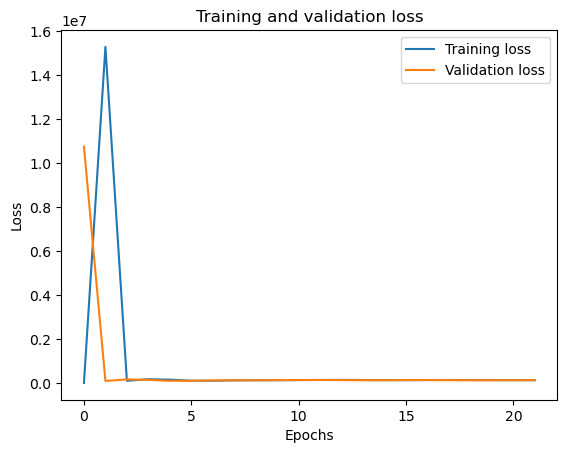

In [11]:
# plot loss history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend(['Training loss', 'Validation loss'], loc='upper right');
plt.show()


1.	High initial loss: Both training and validation loss start extremely high—on the order of  10^7 . This is expected because at initialization, the network produces poor reconstructions.
2.	Rapid drop after 1–2 epochs: Loss falls drastically in early epochs. The model quickly learns basic patterns.
3.	Stabilization after ~10 epochs:
	-	Both training and validation loss flatten out and remain low and stable.
	-	Very small fluctuations (spikes) are seen occasionally—likely due to batch-level variation or KL divergence contributing sharp penalties.
4.	No overfitting: Validation loss closely tracks training loss throughout, which means:
	-	The model generalizes well.
	-	There is no significant gap between train and validation loss curves.

#8. Total loss over all test samples.

In [12]:
score = vae.evaluate(X_test, X_test, verbose = 1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 128384.9375


Returns the average total loss over all test samples.

# 9. Binary Labeling
* y_pred = vae.predict(X_test)
	-	Reconstructs the test data using the VAE.
	-	Output: y_pred is the reconstructed version of X_test.

* y_dist = np.linalg.norm(X_test - y_pred, axis = -1)
	-	Computes the L2 norm (Euclidean distance) between original and reconstructed samples for each test example.
	-	This measures how well the model was able to reconstruct each input.
	-	Assumption: Normal data reconstructs well (low distance), anomalies reconstruct poorly (high distance).

* threshold = np.quantile(y_dist, 0.75)
	-	Computes the 75th percentile of reconstruction distances.
→ Only the top 25% highest-error samples will be labeled as anomalies.
	-	This is a statistical threshold, commonly used when labels are not available during training.
	-	Alternatively, you could set a manual threshold (as commented out: threshold = 37.5).

In [13]:
y_pred = vae.predict(X_test)
y_dist = np.linalg.norm(X_test - y_pred, axis = -1)
threshold = np.quantile(y_dist, 0.75)
#threshold = 37.5

z = zip(y_dist >= threshold, y_dist)
y_label=[]
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


# 10. ROC AUC score

In [14]:
from sklearn.metrics import confusion_matrix, roc_auc_score

roc_auc_score(y_test, y_label)

0.9116666666666665

# 11. Confusion Matrix

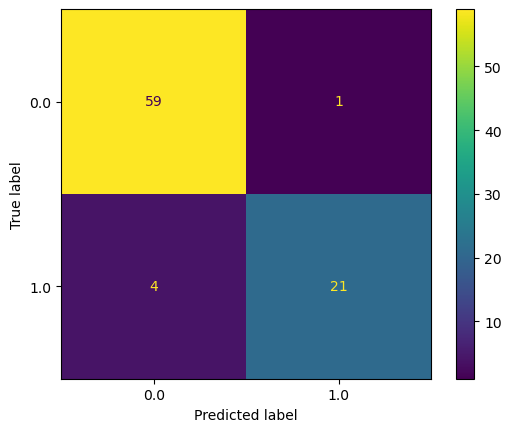

In [15]:
#draw_confusion_matrix(y_test, y_label)

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
   y_test, y_label)
plt.show()

In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_label))

              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96        60
         1.0       0.95      0.84      0.89        25

    accuracy                           0.94        85
   macro avg       0.95      0.91      0.93        85
weighted avg       0.94      0.94      0.94        85



*	Normal samples (0.0):
	-	Detected with high accuracy (96% F1)
	-	Almost all true normal samples were correctly labeled.
*	Cancer samples (1.0):
	-	Slightly lower recall: 84%
→ means 16% of actual cancer samples were missed.
	-	But precision is high: 95%
→ means when the model says “this is cancer,” it’s usually correct.

y_test shape: (85,)
y_dist shape: (85,)


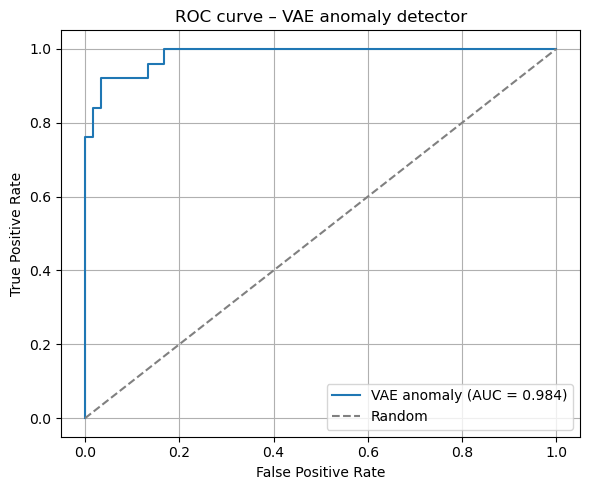

In [18]:
from sklearn.metrics import roc_curve, auc

y_pred = vae.predict(X_test, batch_size=256, verbose=0)

y_dist = np.linalg.norm(X_test - y_pred, axis=1)

print("y_test shape:", np.array(y_test).shape)
print("y_dist shape:", y_dist.shape)

# 3) ROC curve
fpr, tpr, _ = roc_curve(y_test, y_dist)  # y_dist = anomaly score
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"VAE anomaly (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve – VAE anomaly detector")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

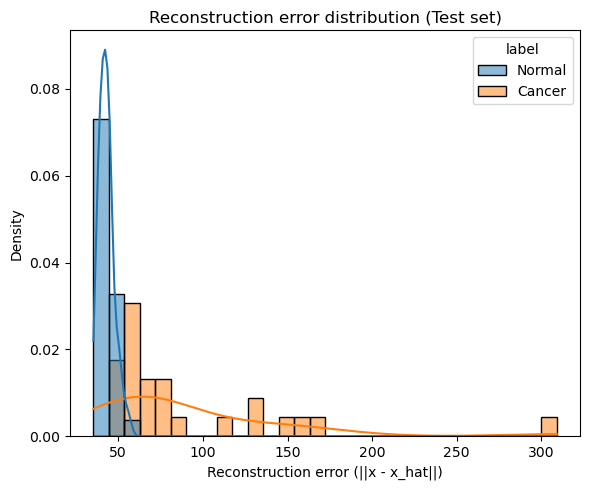

In [20]:
# New Cell: Reconstruction error distribution by class
import seaborn as sns

errors_df = pd.DataFrame({
    "recon_error": y_dist,
    "label": np.where(y_test == 1, "Cancer", "Normal")
})

plt.figure(figsize=(6, 5))
sns.histplot(
    data=errors_df,
    x="recon_error",
    hue="label",
    bins=30,
    kde=True,
    stat="density",
    common_norm=False,
)
plt.title("Reconstruction error distribution (Test set)")
plt.xlabel("Reconstruction error (||x - x_hat||)")
plt.tight_layout()
plt.show()